In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manithj/oily-and-dry-skin-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1


In [ ]:
import os
folders = os.listdir(path)
print("Folders in dataset:", folders)

Folders in dataset: ['Oily-Dry-Skin-Dataset']


In [ ]:
dataset_path = os.path.join(path, "Oily-Dry-Skin-Dataset")
print("Contents of dataset_path:", os.listdir(dataset_path))

Contents of dataset_path: ['valid', 'train', 'test']


In [ ]:
# Set the updated path to "Oily-Dry-Skin-Dataset"
dataset_path = os.path.join(path, "Oily-Dry-Skin-Dataset")

# Check the contents of the dataset folder (train, test, valid)
for split in os.listdir(dataset_path):
    split_path = os.path.join(dataset_path, split)
    print(f"\nProcessing split: {split} (Path: {split_path})")

    # Loop through each class in the split
    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        print(f"  Class: {class_folder} (Path: {class_path})")

        # Loop through each file in the class folder
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            print(f"    File: {image_file} (Path: {image_path})")


Processing split: valid (Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/valid)
  Class: Normal (Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/valid/Normal)
    File: processed_skin_normal_a6dff754a88c5cb6583d_jpg.rf.2e56245d5ec16fdd410f6af402a020f2.jpg (Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/valid/Normal/processed_skin_normal_a6dff754a88c5cb6583d_jpg.rf.2e56245d5ec16fdd410f6af402a020f2.jpg)
    File: processed_skin_normal_5e56ac432e22b07dfb0f_jpg.rf.4fccb318cf8d587afb1b3b36ea8e2aac.jpg (Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/valid/Normal/processed_skin_normal_5e56ac432e22b07dfb0f_jpg.rf.4fccb318cf8d587afb1b3b36ea8e2aac.jpg)
    File: processed_skin_normal_345dd34485c5ef28aeb8_jpg.rf.7510e70e8d78d2a169192169a5037fd5.jpg (Path: /root/.cache/k

In [ ]:
# Paths to the train, test, and valid directories
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")

# Print the paths
print("Train Path:", train_path)
print("Test Path:", test_path)
print("Valid Path:", valid_path)

Train Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/train
Test Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/test
Valid Path: /root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/valid


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/train"
test_dir = "/root/.cache/kagglehub/datasets/manithj/oily-and-dry-skin-dataset/versions/1/Oily-Dry-Skin-Dataset/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 2756 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 2756 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url, num_classes=3):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer,
      should be equal to number of target classes, default = 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="EfficientnetB0_model",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  # Create our image model
  model = tf.keras.Sequential([
    feature_extractor_layer,    # use the feature extraction layer as the base
    layers.Dense(num_classes, activation="softmax", name="output_layer")   # create our own output layer
  ])
  return model

In [ ]:
!pip install tensorflow-hub==0.12.0
!pip install tensorflow==2.9.0


In [ ]:
efficientnet_model = create_model(efficientnet_url,
                            num_classes=3)
# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=valid_data)

Epoch 1/5
87/87 [==============================] - 174s 2s/step - loss: 1.0637 - accuracy: 0.4521 - val_loss: 1.0623 - val_accuracy: 0.3955
Epoch 2/5
87/87 [==============================] - 166s 2s/step - loss: 0.9835 - accuracy: 0.5287 - val_loss: 1.0587 - val_accuracy: 0.4627
Epoch 3/5
87/87 [==============================] - 167s 2s/step - loss: 0.9377 - accuracy: 0.5606 - val_loss: 1.0592 - val_accuracy: 0.4552
Epoch 4/5
87/87 [==============================] - 170s 2s/step - loss: 0.9048 - accuracy: 0.5889 - val_loss: 1.0838 - val_accuracy: 0.4403
Epoch 5/5
87/87 [==============================] - 166s 2s/step - loss: 0.8731 - accuracy: 0.6168 - val_loss: 1.0599 - val_accuracy: 0.5000


In [ ]:
efficientnet_model.save('saved_model/my_model')

In [ ]:
model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Keras  (None, 1280)             4049564   
 Layer)                                                          
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Dry' 'Normal' 'Oily']


In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  print('Prediction Probabilities : ', pred[0])

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 1s 998ms/step
Prediction Probabilities :  [0.32922873 0.21993063 0.4508406 ]


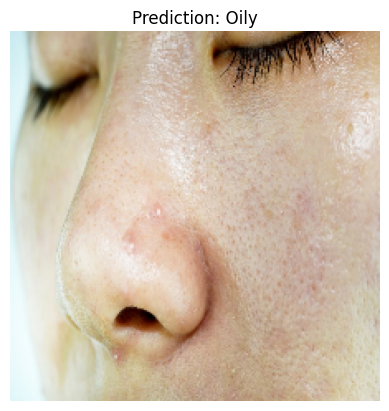

In [ ]:
# Make a prediction using model_1
pred_and_plot(model=model,
              filename="/content/test_image.jpg",
              class_names=class_names)

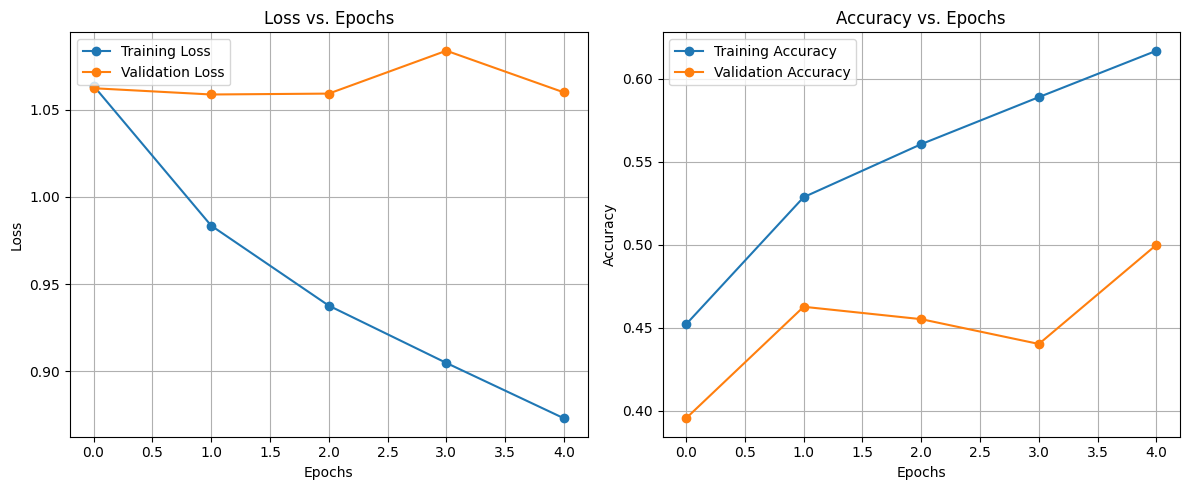

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training vs validation metrics
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the history object.
    Args:
        history: A TensorFlow/Keras History object containing model training details.
    """
    # Extract values from the history object
    epochs = range(len(history.history['loss']))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function with your model history
plot_training_history(efficientnet_history)
